In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
import sys
import os

In [5]:
sys.path.append(os.path.abspath('../packages/merganser_bezier/include/'))

In [6]:
from merganser_bezier import bezier

# Initialisation

In [48]:
controls = np.random.normal(size=(10, 2))

In [49]:
controls = np.array([
    [0, 1],
    [1, 0],
    [2, 3],
    [3, 0],
])

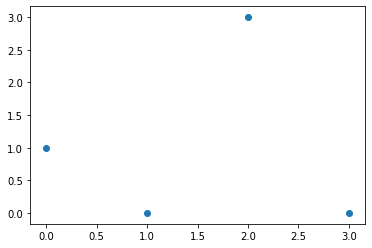

In [50]:
plt.scatter(*controls.T)

In [51]:
ts = np.linspace(0, 1, 100)

In [52]:
curve = np.array([bezier.compute(t, controls) for t in ts])

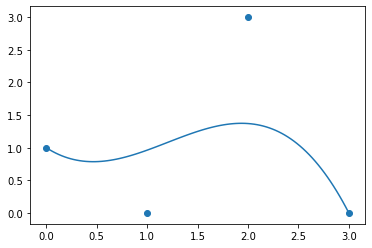

In [53]:
plt.scatter(*controls.T)
plt.plot(*curve.T)

In [54]:
cloud = np.random.normal(size=curve.shape) * .1 + curve

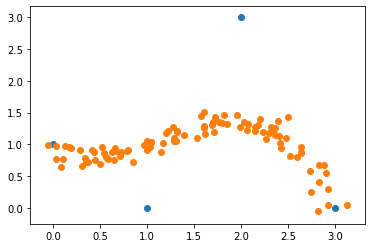

In [55]:
plt.scatter(*controls.T)
plt.scatter(*cloud.T)

# Fitting the Bezier curve

## Initialisation

In [94]:
b = bezier.Bezier(4, 100, choice=cloud)
# b = bezier.Bezier(4, 100, None)

choice = np.array([
    [0, 1],
    [1, 1],
    [2, 1],
    [3, 1],
])
# b = bezier.Bezier(4, 100, choice)
# b = bezier.Bezier(4, 100, controls)

In [95]:
b.extrapolate(-.1, 1.1)

In [96]:
def plot_bezier(b, cloud, true_controls=None):
    
    if true_controls is not None:
        curve = bezier.compute_curve(true_controls)
        plt.scatter(*true_controls.T, color='C0')
        plt.plot(*curve.T, color='C0')

    plt.scatter(*cloud.T, color='C1')

    plt.scatter(*b.controls.T, color='C3')
    plt.plot(*b().T, color='C3')

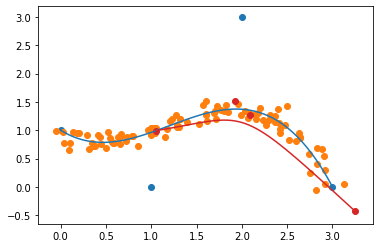

In [97]:
plot_bezier(b, cloud, controls)

## Loss & training strategy

In [98]:
b.loss(cloud)

0.08798810926305752

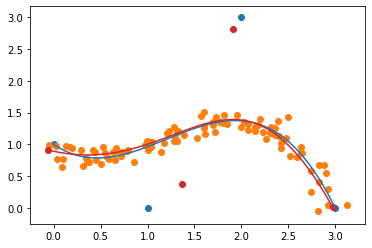

In [106]:
b.fit(cloud=cloud, steps=20)
plot_bezier(b, cloud, controls)

## Fitting

In [92]:
def animate_fitting():
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(xlim=(-1, 4), ylim=(-1, 4))
    ax.scatter(*controls.T, color='C0')
    ax.plot(*curve.T, color='C0')

    ax.scatter(*cloud.T, color='C1')

    line, = ax.plot([], [], color='C3')
    anchors, = ax.plot([], [], 'bo', color='C3')

    # initialization function: plot the background of each frame
    def init():

        line.set_data(*b().T)
        anchors.set_data(*b.controls.T)
        return line,

    # animation function.  This is called sequentially
    def animate(i):
        b.fit(cloud, steps=1)
        line.set_data(*b().T)
        anchors.set_data(*b.controls.T)
        return line,

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=100, interval=10, blit=True)
    
    return anim

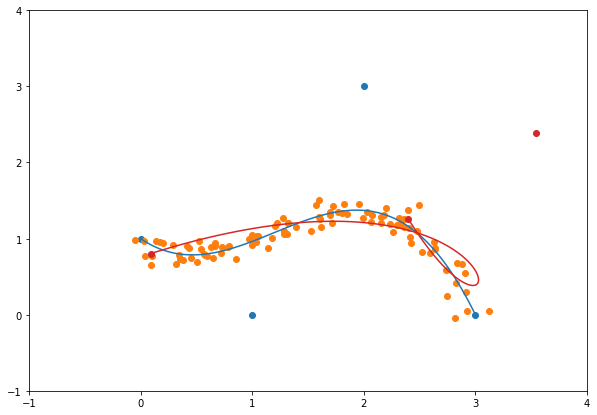

In [93]:
anim = animate_fitting()
anim.save('output/extrapolation-init.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

# Extending the curve

## De Casteljau's algorithm

In [42]:
anchors = controls.copy()

In [45]:
new_anchors = bezier.extrapolate(anchors, 0.2, 1.1)

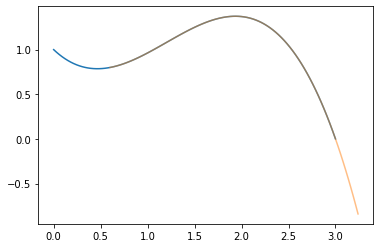

In [46]:
plt.plot(*bezier.compute_curve(anchors).T)
plt.plot(*bezier.compute_curve(new_anchors).T, alpha=.5)

In [ ]:
b.extrapolate()

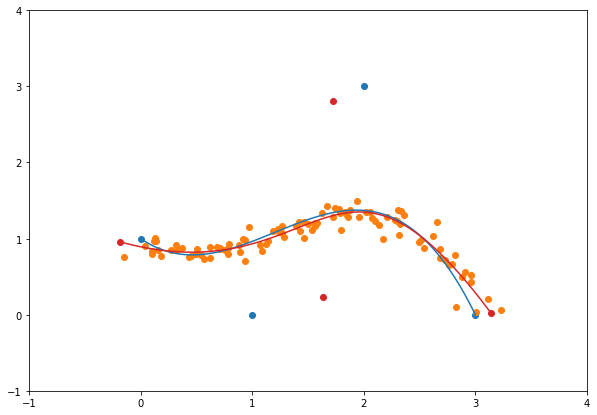

In [41]:
anim = animate_fitting()
anim.save('output/extrapolation-init.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

# Using JAX

In [476]:
import autograd.numpy as np   # Thinly-wrapped version of Numpy
from autograd import grad

In [501]:
inputs = np.array([bezier.bernstein(t, 4) for t in np.linspace(0, 1, 100)])

In [502]:
init = b.controls.data.numpy().copy()
init

array([[0.02856632, 0.45677713],
       [1.8798162 , 1.3646202 ],
       [1.8423913 , 1.293102  ],
       [2.616873  , 1.17195   ]], dtype=float32)

In [503]:
c = cloud.numpy().copy()

In [504]:
from autograd.misc.optimizers import adam

In [509]:
def objective(params, *args):
    curve = np.matmul(inputs, params)
    diff = curve.reshape(-1, 1, 2) - c.reshape(1, -1, 2)
    se = (diff ** 2).mean(axis=2)
    
    return se.min(axis=0).mean() + 5e-3 * se[[0, -1]].min(axis=1).mean()

In [510]:
objective(init)

0.05889137534980616

In [511]:
curve = np.matmul(inputs, p)

In [512]:
diff = curve.reshape(-1, 1, 2) - c.reshape(1, -1, 2)

In [513]:
diff.shape

(100, 100, 2)

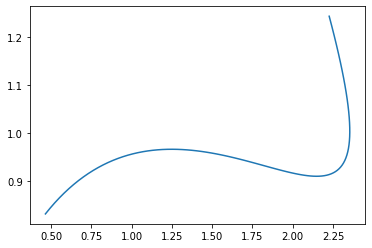

In [514]:
plt.plot(*curve.T)

In [515]:
gradient = grad(objective)

In [516]:
gradient(init)

array([[ 0.02328777, -0.04842852],
       [ 0.00887585, -0.02190493],
       [ 0.00351441, -0.01145158],
       [-0.01570666,  0.09728803]])

In [517]:
optimized_params = adam(gradient, init, step_size=.2,
                            num_iters=1000) #, callback=print_perf)

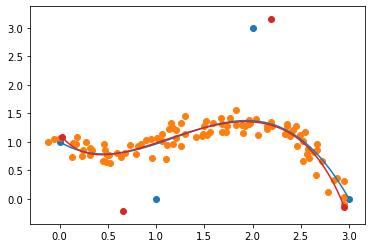

In [518]:
b2 = bezier.Bezier(4, 100, optimized_params)
# b2.controls.data = torch.Tensor(p)
plot_bezier(b2, cloud, controls)
plt.show()

In [396]:
p = init.copy()

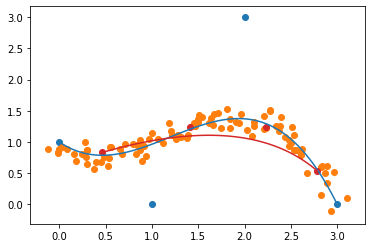

In [454]:
for _ in range(10):
    p -= 1 * gradient(p, 2)

b2 = bezier.Bezier(4, 100, p)
# b2.controls.data = torch.Tensor(init)
plot_bezier(b2, cloud, controls)
plt.show()

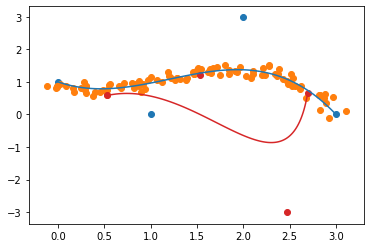

In [201]:
b2 = bezier.Bezier(4, 100, optimized_params)
# b2.controls.data = torch.Tensor(p)
plot_bezier(b2, cloud, controls)
plt.show()